In [1]:
import datetime
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
import pandas.io.formats.style 
sns.set(style="darkgrid")
import matplotlib.ticker as tkr
from matplotlib.gridspec import GridSpec

import geopandas
import re

con = pymysql.connect('localhost', 'root', 'HIDDEN', 'HIDDEN')

<strong>This notebook is only used for pulling data from the database via stored query, and then creating visualizations. Data wrangling is kept to a minimum by keeping the column names from the database tables, and joining the tables through MySQL directly. The column names are kept for data integrity purposes, to keep metadata as close as possible to the database column attributes. 

The only data wrangling which occurs, happens in the visualization functions when the data is passed into it.  This ensures the data is not manipulated and having to fetch / wrangle it again, thus leaving a user to inspect the data from the top of the file, or the bottom and the values are the same.

Logic for the plots are done in consideration with Business Intelligence (or as close as possible), brining one plot after the other to show correlations between them. Drilling down from the most basic values are also considered
</strong>


In [2]:
#acquiring relevant sales data with mysql stored procedures: saves time from manipulating data with Python
def select_main():
    con.connect()
    select = con.cursor()
    statement = 'call customer_orders();'
    select.execute(statement)
    data = select.fetchall()
    con.commit()
    
    data = pd.DataFrame(data)
    
    desc = select.description
    columns = [i[0] for i in desc]
    data.columns=columns
    
    data.index = pd.to_datetime(data.OrderDate)
    data = data.drop(columns='OrderDate')
    data['Total'] = data['Price'] * data['Quantity']
    
    return data

In [3]:
#stored data in memory
data = select_main()

In [47]:
#this function passes the plots into two subplots: monthly data to view growth drivers and a performance card
def sales_intro(data):
    #main plot, two axes
    sales = data.groupby([data.index.year,data.index.month]).aggregate({'Total':'sum'})
    volume = data.groupby([data.index.year,data.index.month]).aggregate({'CustomerName':'nunique'})
    
    
    ax[0].bar((sales.reset_index(drop=True).index + .2).to_list(),sales.reset_index(drop=True)['Total'].values,color='red',width=.2,label=sales.columns[0])
    ax2 = ax[0].twinx()
    ax2.bar(volume.reset_index(drop=True).index.to_list(),volume.reset_index(drop=True)['CustomerName'].values,color='blue',width=.2,label=volume.columns[0])
    
    #formatting labels, axis and titles
    fmt = '€{x:,.0f}'
    tick = tkr.StrMethodFormatter(fmt)
    ax[0].yaxis.set_major_formatter(tick)

    fmt = '{x:,.0f} pcs'
    tick = tkr.StrMethodFormatter(fmt)
    ax2.yaxis.set_major_formatter(tick)
    ax2.grid(b=None)

    h1, l1 = ax2.get_legend_handles_labels()
    h2, l2 = ax[0].get_legend_handles_labels()

    ax[0].legend(h1+h2, l1+l2)
    
    ax[0].set_ylabel('sales toal per month')
    ax2.set_ylabel('volume of customers per month')
    ax[0].set_xlabel('sales season')
    ax[0].set_title('sales performance: sales total and customer volue by month, year.')
    
    data['indexer'] = data.index.strftime('%b %Y')
    dates = list(data.sort_index().indexer.unique())
    dates.insert(0,0)
    
    ax[0].set_xticklabels(dates, rotation = 'horizontal')

    #annotate main plot
    annot = sales.merge(volume,left_index=True,right_index=True).reset_index(drop=True)
    
    for loc, value in enumerate(annot.values):
        ax2.annotate('   '+str(int(value[1]))+' pcs\n€ '+str(format(int(value[0]), ',d')),xy=(loc-.1,value[1]+.2),fontsize=9,horizontalalignment='left')

    #annotate subplot for business intelligence card
    annot_2 = data.aggregate({'CustomerName':'nunique','City':'nunique','Country':'nunique','CategoryName':'nunique','ProductName':'nunique','Price':'mean','OrderID':'count','Quantity':'sum','Total':'sum'}).astype(int)
    new_index = ['customers','cities','countries','categories','products','average product price (euros)','sales orders','quantity sold (pcs)','sales total (euros)']
    annot_2.index = new_index

    annot_2 = pd.DataFrame(annot_2).reset_index() #np.array(list(np.arange(.75,.0,-.25))*3)
    annot_2['y_loc'] =  np.array(list(np.arange(.75,.0,-.25))*3) #np.array(list(np.arange(.25,1,.25))*3)
    annot_2['x_loc'] = np.repeat(np.array([[.1,.4,.7]]), 3)
    
    for i in annot_2.values:
        plot_indice = i[3]
        y_loc = i[2]
        text_string = str(i[0])+': '+ str(format(int(i[1]), ',d'))
        ax[1].text(text=text_string,x=plot_indice,y=y_loc,s=10)
    
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('to date business data')
    
    ax[1].spines['bottom'].set_color('0.5')
    ax[1].spines['top'].set_color('0.5')
    ax[1].spines['right'].set_color('0.5')
    ax[1].spines['left'].set_color('0.5')


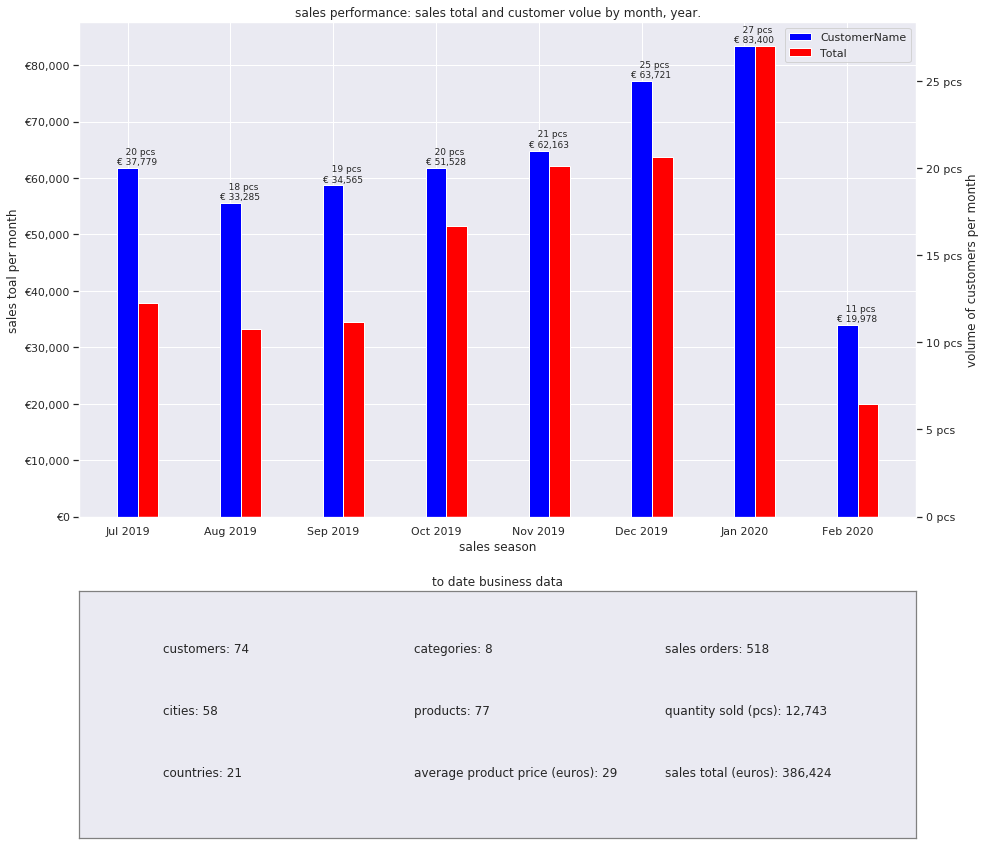

In [49]:
#subplots provided with adjusted height, drivers of growth and performance card
fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[2,1]},figsize=(15,15))
sales_intro(data)

In [6]:
#this function fetches the latitude/longitude with the city name from the database
#the table was created manually (not downloaded)
#values created from w3_get_points.ipynb, passing table city names to geopy API and inserting it into new table
def get_points():
    con.connect()
    select = con.cursor()
    select.callproc('get_points')
    points = select.fetchall()
    
    desc = select.description
    columns = [i[0] for i in desc]
   
    con.commit()
    points = pd.DataFrame(points)
    points.columns=columns
    return points

In [7]:
#this function focuses the map of which countries have sales, and colors binned by values
#separate points plotted on the same map, sized/colored according to how many occurrences city had in table
def world_plot(data):
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world.sort_values('name')
    
    world['Total'] = np.nan
    world[world.name.isin(np.unique(data.Country.values))].sort_values('name').total = data.groupby('Country').aggregate({'Total':'sum'})
    world.loc[world.name.isin(np.unique(data.Country.values)),'Total'] = data.groupby('Country').aggregate({'Total':'sum'}).values
    
    fig = world.plot(column='Total',missing_kwds={'color': 'lightblue',"hatch": "///",'alpha':.5,"label": "no customers"},ax=ax, legend=True,cmap='winter',edgecolor='black',scheme='quantiles',legend_kwds=dict(loc=3),alpha=.8,label='sales')
    
    legend_labels = fig.get_legend().get_texts()
    
    for i in legend_labels:
        if 'customers' in i.get_text():
            pass
        else:
            splitter = re.sub("[\()\[\]]", "", i.get_text()).split(',')
            first  = ('€ {:,.2f}'.format(float(splitter[0])))
            second = ('{:,.2f}'.format(float(splitter[1])))
            new_label = first +' - '+ second
            i.set_text(new_label)
    
    ax.set_ylim([-60, 91])
    ax.set_xlim([-180, 35])
    ax2 = ax.twinx()
    ax2.grid(b=None)
    
    points = get_points()
    cities = geopandas.GeoDataFrame(points, geometry=geopandas.points_from_xy(points.longitude, points.latitude))
    cities.plot(column='density',cmap='cool',categorical=True,markersize=cities['density']*25,alpha=.8,legend=True,label='customers',edgecolors='black',ax=ax2,legend_kwds=dict(loc=6))
    
    ax.set_title("sales by country and customer density by city, current values", fontsize=15)
    
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((.0, .0, 0.2, 0.2))
    leg = ax2.get_legend()
    leg.set_bbox_to_anchor((.0, .0, 0.6, 0.55))


/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


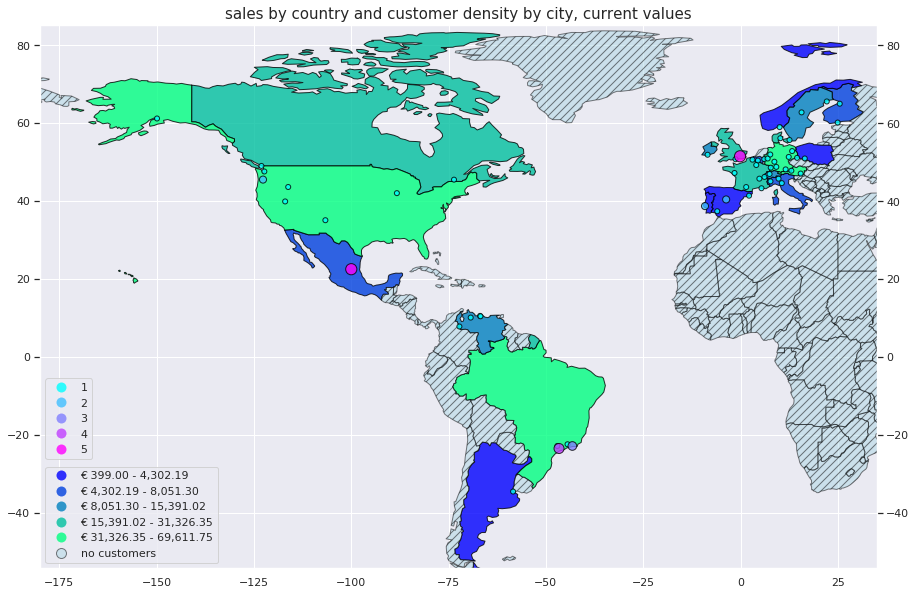

In [8]:
#one subplot, world map business data
fig, ax = plt.subplots(1, 1,figsize=(15, 10))
world_plot(data)

In [9]:
#functions shows in percentage which countries take up what portion of the sales values over time
def country_domination(data):
    country_log = pd.pivot_table(index=data.index,columns='Country',data=data,values='Total',aggfunc=np.sum).fillna(0).cumsum()
    indexer = data.groupby('Country').sum().sort_values('Total').index
    
    (country_log.div(country_log.sum(axis=1), axis=0) * 100)[indexer].plot.area(ax=ax,alpha=.4,cmap='gist_ncar_r').yaxis.set_major_formatter(tkr.PercentFormatter())
    ax.set_title('market share: total sales by country over time')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Country', loc='upper left', bbox_to_anchor=(1.05, 1.01))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

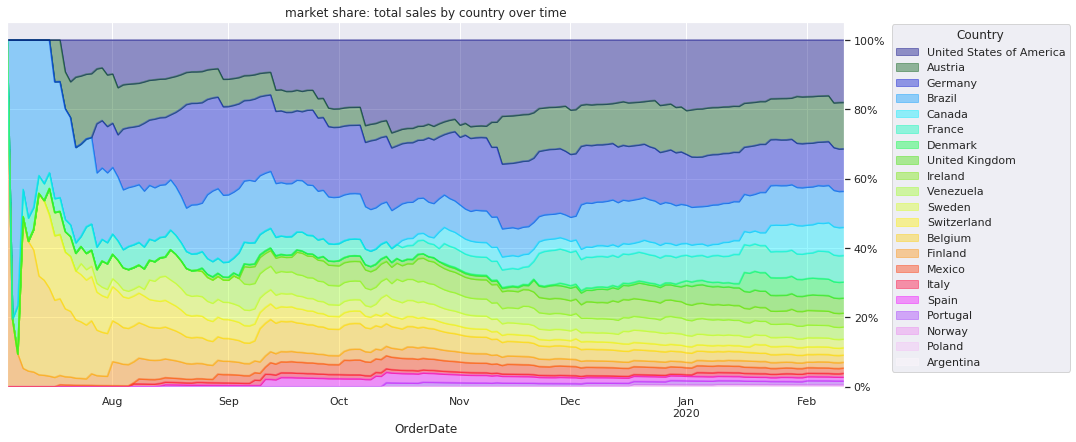

In [10]:
#business data grouped by country, by percentage over time
fig, ax = plt.subplots(1, 1,figsize=(15, 6.7))
country_domination(data)

In [11]:
#function has lots of info, but it is grouping sales country by sum, average order value and quantity
#yellow values are hued according to mean value
#stacked bars given to sales total to show size of category purchases
def country_sales_cat(data):
    sales = pd.pivot_table(data,index='Country',columns='CategoryName',values=['Total','Quantity'],aggfunc=np.sum)
    sales['Total','avg'] = sales['Total'].mean(axis=1)
    sales['Quantity','avg'] = sales['Quantity'].mean(axis=1)
    
    sales = sales
    
    sales['Total'].sort_values('avg')[sales['Total'].columns[:-1]].plot.barh(ax=ax,stacked=True,cmap='bwr',alpha=.8,edgecolor='b',position=0.5,width=0.25)
    
    
    y = sales['Quantity'].loc[sales['Total'].sort_values('avg').index]['avg'].values

    my_cmap = plt.get_cmap("Wistia")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    
    sales['Total'].sort_values('avg')[sales['Total'].columns[-1]].plot.barh(ax=ax,legend=True,color=my_cmap(rescale(y)),label='Mean total per category, hue by mean quantity',edgecolor='b',position=1.5,width=0.25)
    
    fmt = '€{x:,.0f}'
    tick = tkr.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)

    for country, total,quantity in zip(np.arange(0,len(sales.index)),sales['Total'].sort_values('avg')['avg'],sales['Quantity'].loc[sales['Total'].sort_values('avg').index]['avg'].values):
        ax.annotate('€ '+str(format(int(total), ',d')) +' / ' +  str(int(quantity)) + ' pcs',xy=(int(total)+400, country-0.35),horizontalalignment='left',color='black',fontsize=8)
    
    for country, total in zip(np.arange(0,len(sales.index)),sales['Total'].sort_values('avg')[sales['Total'].columns[:-1]].sum(axis=1).values):
        ax.annotate('€ '+str(format(int(total), ',d')),xy=(int(total)+400,country-0.08),fontsize=8)
    
    ax.set_title('total purchases by category and country; mean category total hued by quantity')

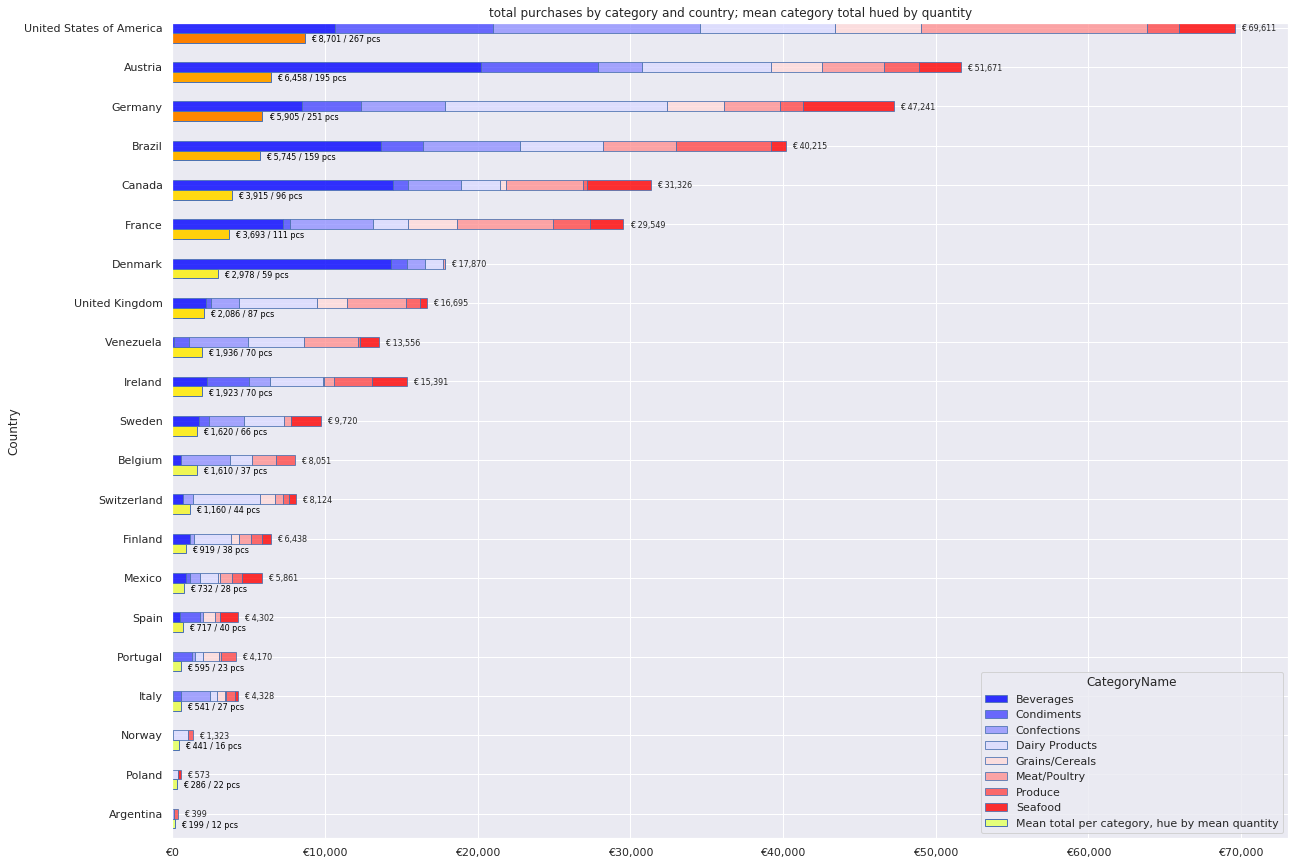

In [12]:
#business data by country, category, mean sales order value and quantity
fig, ax = plt.subplots(figsize=(20,15))
country_sales_cat(data)

In [13]:
#seven day rolling average, cumulative mean sales aggregate by category over time
#show which category sales are boosting growth values, namely beverages
def cat_log(data):

    logger = pd.pivot_table(data,index=[data.index],columns='CategoryName',values='Total')
    reindexer = pd.date_range(logger.index[0], logger.index[-1])
    logger = logger.reindex(reindexer).fillna(0).cumsum().rolling(7).mean()

    plotter = logger.plot(ax=ax,title='cumulative sales per category, 7 day rolling average',zorder=2,legend=False,linewidth=2)

    ax.legend(loc='upper left')
               
    fmt = '€{x:,.0f}'
    tick = tkr.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    
    ax.set_xlabel("sales season")
    ax.set_ylabel("log of sales in euros")


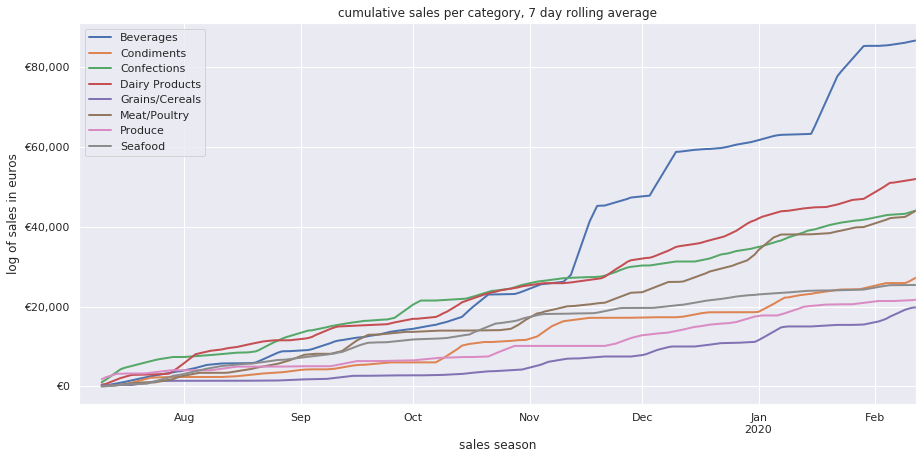

In [14]:
#seven day rolling average, cumulative mean sales aggregate by category over time
fig, ax = plt.subplots(figsize=(15,7))
cat_log(data)

In [15]:
#visual to show deviations from count of orders, customers, products, cities from average over time
#can be used to establish additional growth drivers. mean sales order total and product price also given
def business_vitals(data):
    
    vital_average = data.groupby([data.index.year,data.index.month]).aggregate({'OrderID':'count','ProductID':'nunique','CustomerName':'nunique','City':'nunique','Price':'mean','Quantity':'mean','Total':'mean'}).mean(axis=0)
    vitals = (data.groupby([data.index.year,data.index.month]).aggregate({'OrderID':'count','ProductID':'nunique','CustomerName':'nunique','City':'nunique','Price':'mean','Quantity':'mean','Total':'mean'}) - vital_average)
    indexer = vitals.index.get_level_values(0).astype(str) +'-'+ vitals.index.get_level_values(1).astype(str)
    
    vitals[vitals.columns[:-3]].plot.bar(ax=ax[0],legend=True,cmap='bwr')
    ax[0].set_title('deviation from monthly average: handle of orders, unique products, customers and cities served')

    vitals[vitals.columns[-1]].plot.bar(ax=ax[1],legend=False,color=(vitals[vitals.columns[-1]] >= 0).map({True: '#abffab',False: '#ffabab'}))
    ax[1].set_title('deviation from monthly average: mean sales total per order')
    
    vitals[vitals.columns[-3]].plot.bar(ax=ax[2],legend=False,alpha=.8,color=(vitals[vitals.columns[-3]] >= 0).map({True: '#7fcdfa',False: '#faa87f'}))
    ax[2].set_title('deviation from monthly average: mean price of product in order')

    plt.setp(ax, xticks=np.arange(0,8), xticklabels=indexer)
    for i,s in enumerate(ax):
        plt.setp(ax[i].get_xticklabels(), rotation='horizontal')
        ax[i].set_xlabel("")
        if i in list([1,2]):
            ax[i].set_ylabel('deviation in euros')
        elif i == 0:
            ax[i].set_ylabel('deviation in count')

    fmt = '{x:,.0f} pcs'
    tick = tkr.StrMethodFormatter(fmt)
    ax[0].yaxis.set_major_formatter(tick)

    ax[0].annotate('incomplete sales period',xy=(7,0),horizontalalignment='center',fontsize=8,bbox=dict(boxstyle="Square", fc="white",alpha=.5),xytext=(7, 5),arrowprops=dict(facecolor='black', shrink=0.05))

    for position,value in enumerate(vitals[vitals.columns[-1]].values):
        if value >= 0:
            ax[1].annotate('+ €'+str((value).round(2)),xy=(position,value+5),horizontalalignment='center')
        else:
            ax[1].annotate('- €' + str(abs(value).round(2)),xy=(position,value+5),horizontalalignment='center')

    for position,value in enumerate(vitals[vitals.columns[-3]].values):
        if value >= 0:
            ax[2].annotate('+ €'+str((value).round(2)),xy=(position,value+.1),horizontalalignment='center')
        else:
            ax[2].annotate('- €' + str(abs(value).round(2)),xy=(position,value+.1),horizontalalignment='center')
    

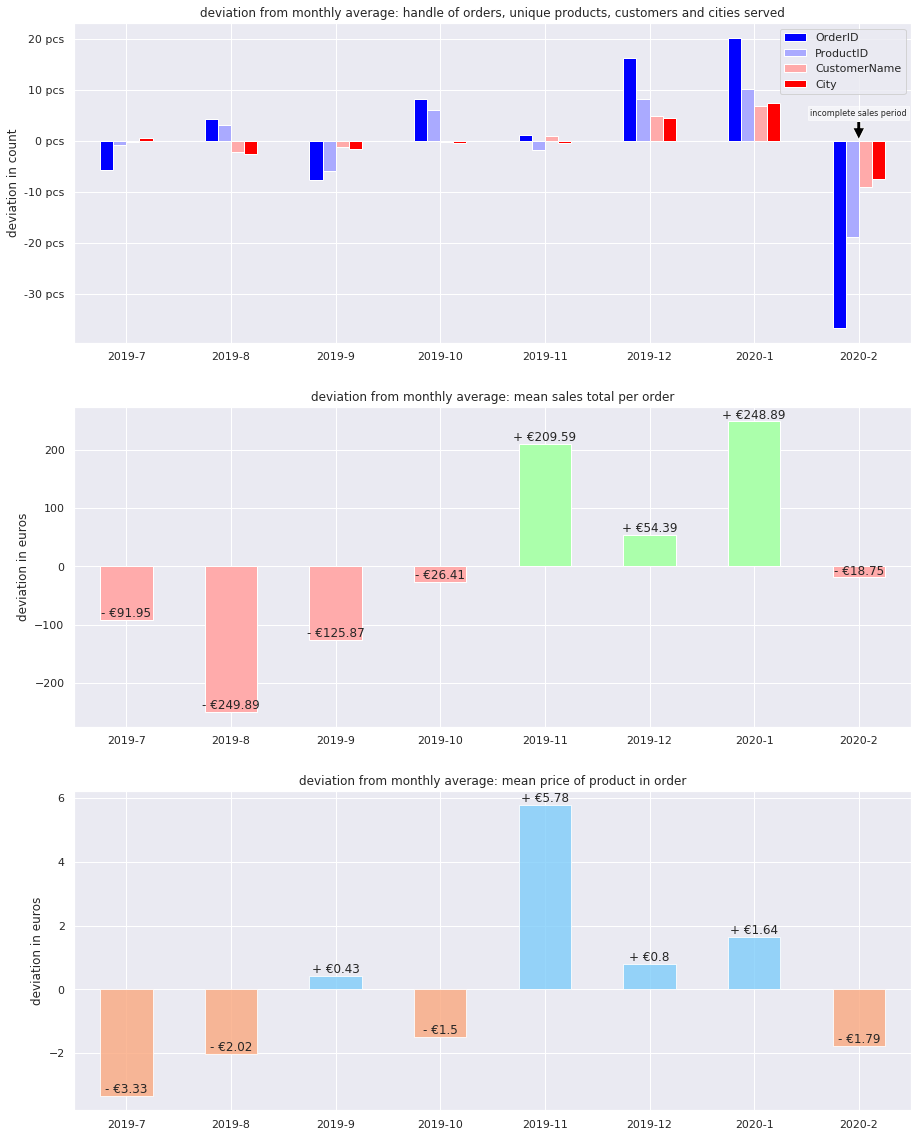

In [16]:
#closer look at what values depart from averages in the time series where growth has occurred
fig, ax = plt.subplots(3,figsize=(15,20))
business_vitals(data)

In [17]:
#correlative plot to bin sales values by all product ids over time, colored by sales total
#high performers colored red, where growth was seen in other charts in those same months
#products which performed highly also annotated 
def product_correlation(data):
    corr = data.reset_index().sort_values('OrderDate')
    corr.OrderDate = corr.OrderDate.dt.strftime('%Y-%m')
    corr['bin'] = pd.cut(corr.Total,bins=[1,1000,5000,10000,13175],labels=['1 - 1,000 (average)','1,001 - 5,000','5,001 - 10,000','10,001 - 13,175'])
    sns.stripplot(x="OrderDate", y="ProductID", data=corr,hue='bin',palette='seismic',ax=ax,marker="o",dodge=True,jitter=False)
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax.set_title('correlation of products by ID number, to bin of sales performance')
    
    indexer = pd.DataFrame({'OrderDate': corr.OrderDate.unique(), 'dates_id':range(len(corr.OrderDate.unique()))})
    corr = corr.merge(indexer, on='OrderDate', how='left')

    annot_filter = corr[corr['bin'] == "10,001 - 13,175"]
    
    x_axis = []
    y_axis = []
    text_strings = []

    for i in annot_filter.values:
        x = i[-1]
        y = i[4]
        text = i[5]
        quantity = str(i[6])
        if x in x_axis:
            updated = int(text_strings[-1][-3:-1]) + int(quantity)
            prod = (text_strings[-1].split("(")[0])
            text_strings[-1] = (prod+' ({})'.format(updated))
        else:
            x_axis.append(x)
            y_axis.append(y)
            text_strings.append(text+' ({})'.format(quantity))

    for string, x,y in zip(text_strings,x_axis,y_axis):
        ax.annotate(string,xy=(x+.3,y+2),fontsize=8,horizontalalignment='center',bbox=dict(boxstyle="Square", fc="white",alpha=.7))

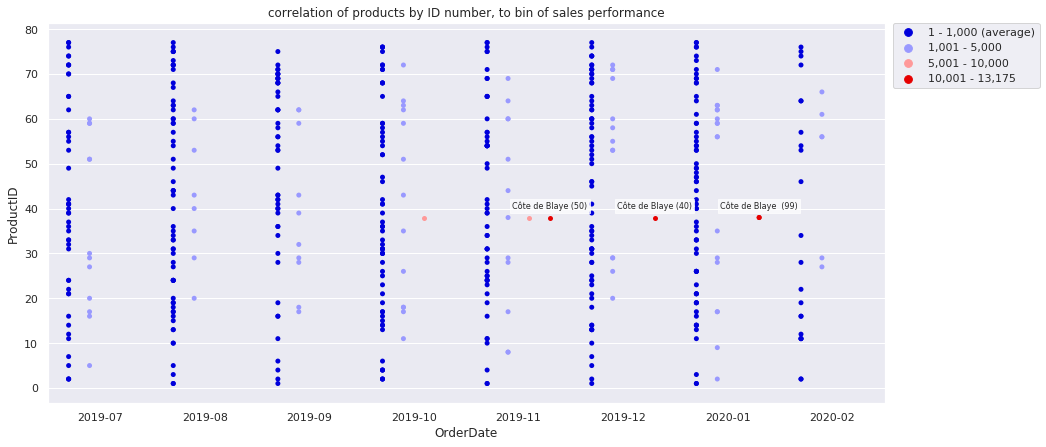

In [18]:
#correlative plot, product id in time series, colored by performance
fig, ax = plt.subplots(figsize=(15,7))
product_correlation(data)

In [19]:
#stored query to fetch employee values, with product/order details for merging 
def employee_merge():
    con.connect()
    select = con.cursor()
    select.callproc('employee_join')
    data = select.fetchall()
    desc = select.description
    columns = [i[0] for i in desc]
    con.commit()
    data = pd.DataFrame(data)
    data.columns=columns
    return data

In [20]:
#plot correlates in the same way, binned values grouped by customer as purchases
#customer ID fetched from table, joined for aggregate plotting
#high performers annotated with customer name, country, product and quantity
def customer_correlation(data):
    emp = employee_merge()
    corr = data.reset_index().merge(emp,how='left', left_on=['OrderID','ProductID'], right_on = ['OrderID','ProductID'])
    corr['bin'] = pd.cut(corr.Total,bins=[1,1000,5000,10000,13175],labels=['1 - 1,000 (average)','1,001 - 5,000','5,001 - 10,000','10,001 - 13,175'])
    corr = corr.sort_values('OrderDate')
    corr.OrderDate = corr.OrderDate.dt.strftime('%Y-%m')
    
    sns.stripplot(x="OrderDate", y="CustomerID", data=corr,hue='bin',palette='seismic',ax=ax,marker="o",dodge=True,jitter=False)
    
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax.set_title('correlation of sales total by Customer ID number, to bin of sales performance. high performers outlined.')
    
    indexer = pd.DataFrame({'OrderDate': corr.OrderDate.unique(), 'dates_id':range(len(corr.OrderDate.unique()))})
    corr = corr.merge(indexer, on='OrderDate', how='left')
    annot_filter = corr[corr['bin'] == "10,001 - 13,175"]
    
    for i in annot_filter.values:
        ax.annotate(i[1] +'\n'+i[2]+'\n'+i[5]+'({})'.format(str(i[6])),xy=(i[-1]-.07,i[12]+3),fontsize=8,horizontalalignment='left',bbox=dict(boxstyle="Square", fc="white",alpha=.8))
    

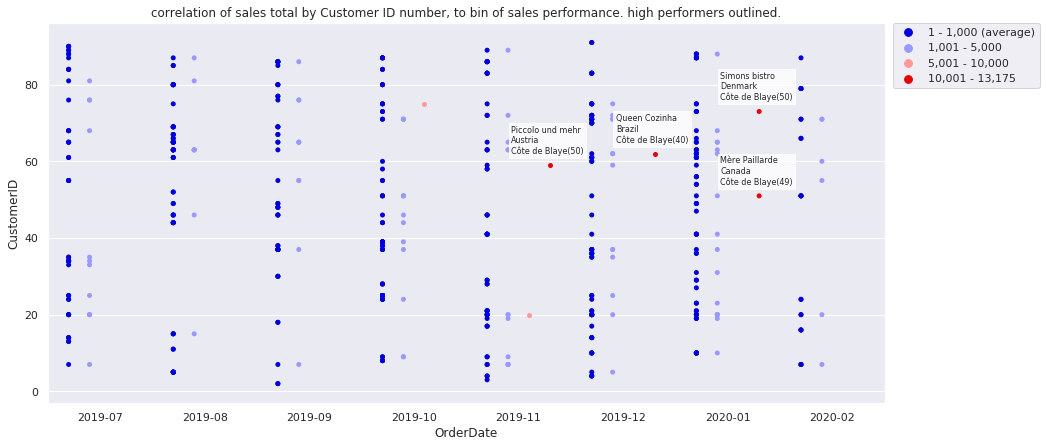

In [21]:
#correlative plot of customer ID to sales total in month, colored by sales total bin
fig, ax = plt.subplots(figsize=(15,7))
customer_correlation(data)

In [22]:
#simple correlative plot, of product price  to quantity
#shows that price * quantity doesn't neccesarily equate to high performance
def corr_quan_price(data):
    emp = employee_merge()
    corr = data.reset_index().merge(emp,how='left', left_on=['OrderID','ProductID'], right_on = ['OrderID','ProductID'])
    corr = corr.groupby(['ProductID','CategoryName','Price']).aggregate({'Quantity':'sum','Total':'sum'})
    corr = corr.reset_index()
    hb = ax.scatter(corr.Quantity,corr.Price,c=corr.Total,cmap='bwr')
    fmt = '€{x:,.0f}'
    tick = tkr.StrMethodFormatter(fmt)
    cb = fig.colorbar(hb, ax=ax,format=tick)
    cb.set_label('sales total to unique product')
    ax.set_ylabel('quantity')
    ax.set_xlabel('price')
    ax.set_title('Correlation of price to quantity sold of unique product, colored by sales total.')

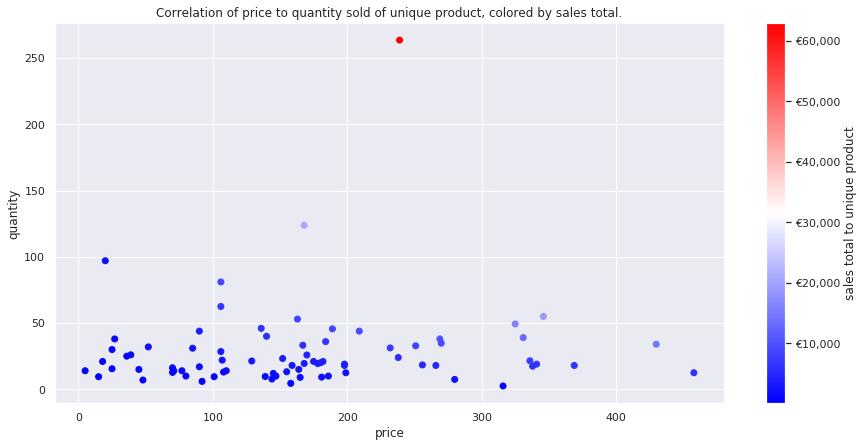

In [23]:
#simple correlative plot, of product price  to quantity
fig, ax = plt.subplots(figsize=(15,7))
corr_quan_price(data)

In [24]:
#log plot grouped sales by Employee name over time, which one is driving sales
def employee_corr_log(data):
    emp = employee_merge()
    emp = pd.merge(data.reset_index(), emp,  how='left', left_on=['OrderID','ProductID'], right_on = ['OrderID','ProductID'])
    emp_log = pd.pivot_table(emp,index='OrderDate',columns='FirstName',values='Total',aggfunc='mean').fillna(0).cumsum().rolling(7).mean()

    emp_log['mean'] = emp_log.mean(axis=1)
    emp_log[emp_log.columns[:-1]].plot(ax=ax)
    emp_log[emp_log.columns[-1]].plot(ax=ax,legend=True,linestyle='-.',color='black')
    fmt = '€{x:,.0f}'
    tick = tkr.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    ax.set_title("log: mean sales total of order, 7 day rolling average")
    ax.set_xlabel("sales season")
    ax.set_ylabel("cost in euros")

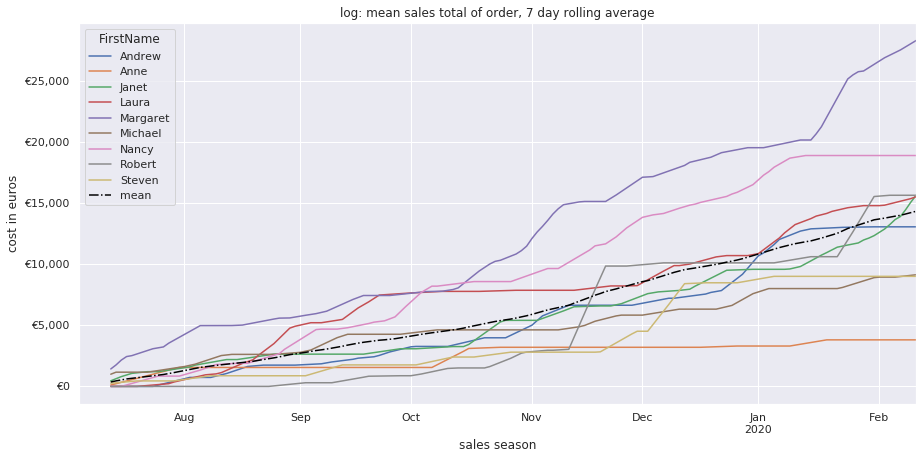

In [25]:
#log plot grouped sales by Employee name over time, which one is driving sales
fig, ax = plt.subplots(figsize=(15,7))
employee_corr_log(data)

In [26]:
#heatmap grouped by Employee name to category, with sales total
#we can see that certain employees are performing much better than others
#beverages was driving sales, and Margaret is the highest sales performer in that category
def employee_heat(data):
    emp = employee_merge()
    emp = pd.merge(data.reset_index(), emp,  how='left', left_on=['OrderID','ProductID'], right_on = ['OrderID','ProductID'])
    emp = pd.pivot_table(emp,index='FirstName',columns='CategoryName',values='Total',aggfunc='sum')
    emp['Total'] = emp.sum(axis=1)
    emp = emp.sort_values('Total',ascending=False)[emp.columns[0:-1]]
    
    im = ax.imshow(emp,cmap='bwr')

    ax.set_yticks(np.arange(len(emp.index)))
    ax.set_xticks(np.arange(len(emp.columns)))

    ax.set_xticklabels(emp.columns)
    ax.set_yticklabels(emp.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")


    for index in enumerate(emp.index):
        for col in enumerate(emp.columns):

            if np.isnan(emp.iloc[index[0]][col[0]]):
                pass
            else:
                ax.annotate(str('€{:,.2f}'.format(emp.iloc[index[0]][col[0]])),xy=(col[0],index[0]),color='black',fontsize=8,horizontalalignment='center')

    fmt = '€{x:,.0f}'
    tick = tkr.StrMethodFormatter(fmt)
    ax.set_ylim(len(emp)-0.5, -0.5)
    ax.grid(b=None)
    ax.set_title('total sales per product category, by employee name.')
    cbar = ax.figure.colorbar(im, ax=ax,format=tick)
    cbar.ax.set_ylabel('sales total in euros', rotation=-90, va="bottom")

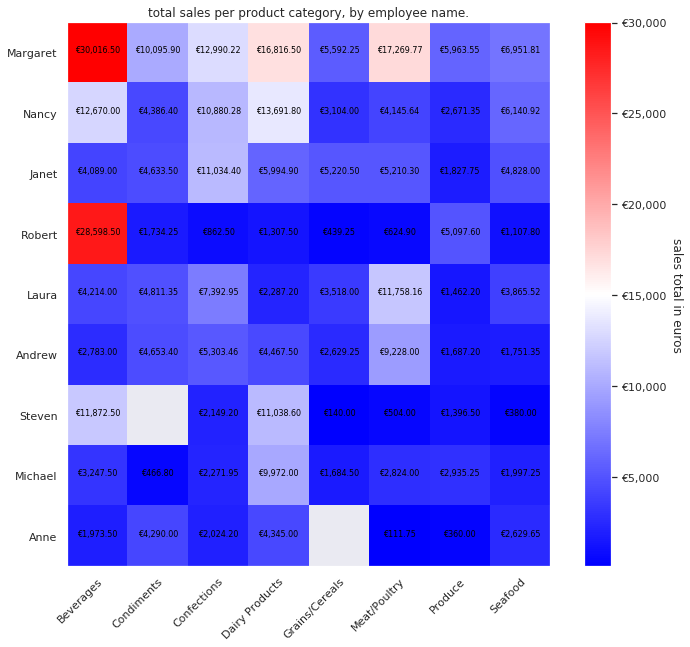

In [27]:
#heatmap of sales by employee
fig, ax = plt.subplots(figsize=(12,10))
employee_heat(data)